In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import random
import networkx as nx

Ising Model MCMC Simulation:

In [2]:
# create n x n board with n^2*p nodes assigned -1 and the rest 1
def gen_board(n, p):
    B = np.ones(n*n)
    B[1:math.floor(n*n*p)] = -1
    np.random.shuffle(B)
    B = B.reshape((n,n))
    return B

In [3]:
def draw_board(B):
    cmap = mpl.colors.ListedColormap(['white', 'black'])
    plt.imshow(B, cmap=cmap, interpolation='none') 

In [4]:
def bond_energy(x, B, n):
    i = x[0]
    j = x[1]
    up    = B[i-1, j] if (i > 0) else 0
    down  = B[i+1, j] if (i < n-1) else 0
    left  = B[i, j-1] if (j > 0) else 0
    right = B[i, j+1] if (j < n-1) else 0
    sum_of_neighbors = up + down + left + right
    return -B[i,j] * sum_of_neighbors

In [5]:
def total_energy(B, n):
    E = 0
    for i in range(n):
        for j in range(n):
            E += bond_energy((i,j), B, n)/2
    return E

In [6]:
def energy_diff_from_swap(x, y, B, n):
    return -2 * (bond_energy(x, B, n) + bond_energy(y, B, n))

In [7]:
def are_adjacent(x, y, n):
    i1 = x[0]
    i2 = y[0]
    i_diff1 = abs(i1 - i2)
    i_diff2 = n - i_diff1
    i_diff = min(i_diff1, i_diff2)
    
    j1 = x[1]
    j2 = y[1]
    j_diff1 = abs(j1 - j2)
    j_diff2 = n - j_diff1
    j_diff = min(j_diff1, j_diff2)
    
    return (i_diff == 0 and j_diff == 1) or (i_diff == 1 and j_diff == 0)

In [8]:
def swap(x, y, B):
    temp = B[x[0], x[1]]
    B[x[0], x[1]] = B[y[0], y[1]]
    B[y[0], y[1]] = temp

In [9]:
n = 18 # board size
p = 0.4 # proportion of states which are spin up
E = None
E_history = []

def metropolis_update(B, n, t):
    global E
    x = np.random.choice(n, 2)
    y = np.random.choice(n, 2)
    if (B[x[0], x[1]] == B[y[0], y[1]]) or are_adjacent(x, y, n): # retry if two positions have same spin or are adjacent
        return metropolis_update(B, n, t)
    dE = energy_diff_from_swap(x, y, B, n)
    if dE <= 0 or (np.random.rand() < math.exp(-dE / t)):
        swap(x, y, B)
        E += dE
        E_history.append(E)

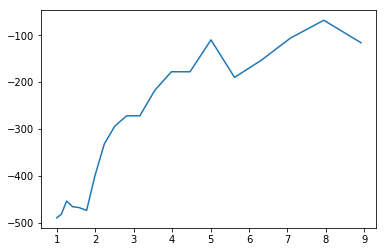

In [10]:
num_iterations = 10000
temps = []
configs = []
energies = []

for a in np.arange(0, 1, 0.05):
    t = 10**a
    B = gen_board(n, p)
    E = total_energy(B, n)
    E_history = [E]
    for j in range(num_iterations):
        metropolis_update(B, n, t)
    temps.append(t)
    configs.append(B)
    energies.append(E)
plt.plot(temps, energies)

Districting MCMC Search

In [11]:
# create n x n square grid graph
def create_square_grid_graph(n, diagonals):
    G = nx.Graph()
    for i in range(n ** 2):
        # the nodes are indexed row first (1st row is indices 0 through 9, 2nd row is indices 10 through 19, etc.)
        row = i // n # result of division is floored
        col = i % n
        # compute indices of relevant adjacent nodes and add edges
        # no need to add W, N, NE, NW because we already visited those nodes
        east  = i + 1
        south = i + n
        if row < n - 1:
            G.add_edge(i, south)
        if col < n - 1:
            G.add_edge(i, east)
        if diagonals:
            southwest = i + n - 1
            southeast = i + n + 1
            if row < n - 1 and col > 0:
                G.add_edge(i, southwest)
            if row < n - 1 and col < n - 1:
                G.add_edge(i, southeast)
    return G

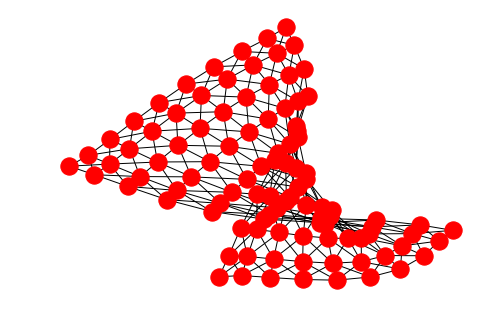

In [12]:
# test create_square_grid_graph_with_diagonals
nx.draw(create_square_grid_graph(10, True))

In [13]:
# create an initial block-layout districting
def create_block_districting(block_width, block_height, num_blocks_across, num_blocks_down):
    num_vertices_across = block_width * num_blocks_across
    num_vertices_down = block_height * num_blocks_down
    num_vertices = num_vertices_across ** 2
    districting = np.zeros(num_vertices)
    for i in range(num_vertices):
        row = i // num_vertices_down
        col = i % num_vertices_across
        block_row = row // block_height
        block_col = col // block_width
        block_index = block_row * num_blocks_across + block_col
        districting[i] = block_index
    return districting

In [14]:
# test create_block_districting
create_block_districting(2, 2, 2, 2)

array([0., 0., 1., 1., 0., 0., 1., 1., 2., 2., 3., 3., 2., 2., 3., 3.])

In [34]:
# change the district of the second node to that of the first
def flip_district(districting, node1, node2):
    districting[node2] = districting[node1]

In [35]:
# test flip_district
d = [1, 2]
flip_district(d, 0, 1)
print(d)

[1, 1]


In [17]:
# remove all edges connected to vertex v in graph G
def remove_edges_from_vertex(G, v):
    neighbors = list(nx.all_neighbors(G, v))
    for neighbor in neighbors:
        G.remove_edge(v, neighbor)

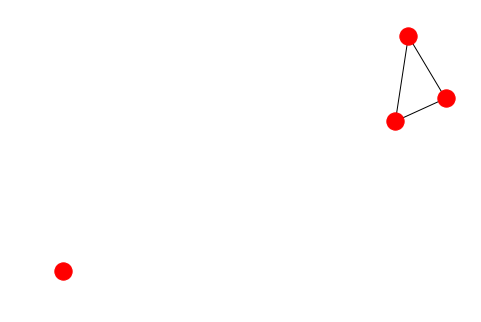

In [20]:
# test remove_edges_to_neighbors
G = create_square_grid_graph(2, diagonals=True)
remove_edges_from_vertex(G, 0)
nx.draw(G)

In [21]:
# look at edges from vertex v in graph G_full
# and add to graph G_d those which connect v to a vertex
# in the same district, according to the district list
def connect_vertex_to_neighbors_in_district(G_d, v, districting, G_full):
    neighbors = list(nx.all_neighbors(G_full, v))
    for neighbor in neighbors:
        if districting[v] == districting[neighbor]:
            G_d.add_edge(v, neighbor)

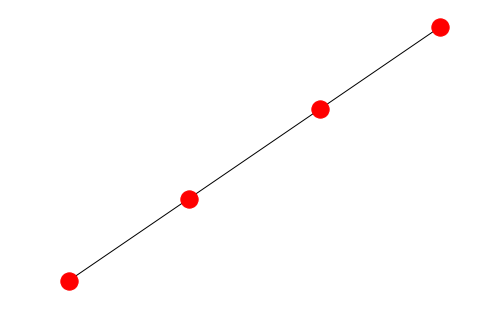

In [23]:
# test connect_vertex_to_neighbors_in_district
G_full = create_square_grid_graph(2, diagonals=True)
G_d = nx.Graph()
G_d.add_edge(0,1)
G_d.add_edge(2,3)
districting = [0,0,0,1]
connect_vertex_to_neighbors_in_district(G_d, 0, districting, G_full)
nx.draw(G_d)
# result should be path on four vertices

In [24]:
# create subgraph of G w/ edges only between vertices in same district
def create_district_subgraph(G, districting):
    G_d = G.copy()
    G_d_edges = list(G_d.edges())
    for edge in G_d_edges:
        v1 = edge[0]
        v2 = edge[1]
        if districting[v1] != districting[v2]:
            G_d.remove_edge(v1, v2)
    return G_d

In [25]:
def update_district_subgraph_after_swap(G, G_d, v1, v2, new_districting):
    remove_edges_from_vertex(G_d, v1)
    remove_edges_from_vertex(G_d, v2)
    connect_vertex_to_neighbors_in_district(G_d, v1, current_districting, G)
    connect_vertex_to_neighbors_in_district(G_d, v2, current_districting, G)

In [36]:
# create initial districting plan by placing 2*3 block grid over 18x18 grid graph
block_width = 9
block_height = 6
num_blocks_across = 2
num_blocks_down = 3

num_vertices_across = block_width * num_blocks_across
num_districts = num_blocks_across * num_blocks_down
nodes_per_district = block_width * block_height

G = create_square_grid_graph(num_vertices_across, diagonals=True)
G_edges = list(G.edges())
num_G_edges = len(G_edges) # number of edges in the grid graph

G_rook = create_square_grid_graph(num_vertices_across, diagonals=False)
G_rook_edges = list(G_rook.edges())

In [ ]:
num_proposals = 200000
current_districting = create_block_districting(block_width, block_height, num_blocks_across, num_blocks_down)
districtings = [current_districting]
rook_districtings = [current_districting]

# G_d (G_district) is the subgraph of G where edges connect nodes in the same district
# G_d should have one connected component per district
G_d = create_district_subgraph(G, current_districting)
G_rook_d = create_district_subgraph(G_rook, current_districting)

for k in range(num_proposals):
    # search for conflicting edge to swap
    still_searching = True
    while still_searching: # Each edge occurs twice in the edge list; a-b and b-a
        r = random.randint(0, num_G_edges - 1)
        edge = G_edges[r]
        v1 = edge[0]
        v2 = edge[1]
        if current_districting[v1] != current_districting[v2]:
            still_searching = False
    # save the original district of v2 in case the flip isn't accepted
    # flip the district of v2 to that of v1
    # update the district graph G_d:
    # - remove all edges connected to v1 or v2
    # - add edges to v1 or v2 based on new districting
    old_v2 = current_districting[v2]
    flip_district(current_districting, v1, v2)
    update_district_subgraph_after_swap(G, G_d, v1, v2, current_districting)
    update_district_subgraph_after_swap(G_rook, G_rook_d, v1, v2, current_districting)
    
    # if the new districting is valid, add it to the list
    # otherwise undo the changes
    G_s = [] # G_subgraphs
    deviant_population = False
    for c in nx.connected_components(G_d):
        size_of_subgraph = nx.number_of_nodes(G_d.subgraph(c))
        if size_of_subgraph > (nodes_per_district + 1) or size_of_subgraph < (nodes_per_district - 1): 
            deviant_population = True
    if nx.number_connected_components(G_d) == num_districts and not deviant_population:
        districting_copy = copy.deepcopy(current_districting) # without a deep copy, updating the current districting would change those already stored in the districtings list
        districtings.append(districting_copy)
        if nx.number_connected_components(G_rook_d) == num_districts:
            districting_copy = copy.deepcopy(current_districting)
            rook_districtings.append(districting_copy)
    else:
        current_districting[v2] = old_v2
        update_district_subgraph_after_swap(G, G_d, v1, v2, current_districting)
        update_district_subgraph_after_swap(G_rook, G_rook_d, v1, v2, current_districting)
plt.imshow(current_districting.reshape((18,18)))

In [29]:
# get unique districtings, not identifying those which labels permuted
unique_districtings = [np.array(x) for x in set(tuple(x) for x in districtings)]
unique_rook_districtings = [np.array(x) for x in set(tuple(x) for x in rook_districtings)]

print(str(len(districtings)) + ' districtings found.')
print(str(len(unique_districtings)) + ' unique districtings found.')
print(str(len(rook_districtings)) + ' rook districtings found.')
print(str(len(unique_rook_districtings)) + ' unique rook districtings found.')

16892 districtings found.
16828 unique districtings found.
2 rook districtings found.
2 unique rook districtings found.


Seat Share Calculations

In [30]:
def get_seat_share(config, districting):
    config_flat = np.reshape(config, len(districting))
    num_districts = int(max(districting)) + 1
    seats = 0
    for d in range(num_districts):
        vote_diff = sum(config_flat[districting == d])
        if vote_diff < 0:
            seats += 1
        elif vote_diff == 0:
            seats += 0.5
    return seats

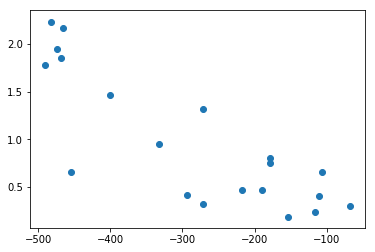

In [31]:
seats = []
for config in configs:
    avg_seats = 0
    for districting in unique_districtings:
        avg_seats += get_seat_share(config, districting)
    avg_seats /= float(len(unique_districtings))
    seats.append(avg_seats)
plt.scatter(energies, seats)

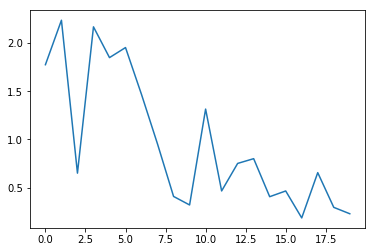

In [32]:
plt.plot(seats)

In [33]:
configs[0]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1., -1.,